In [1]:
# Import dependencies
import torch
import torch.nn as nn
from plot_lib import set_default, show_scatterplot, plot_bases
from matplotlib.pyplot import plot, title, axis

In [2]:
# Set style (needs to be in a new cell)
set_default()

In [3]:
# Set up your device 
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [4]:
# Set up random seed to 1008. Do not change the random seed.
seed = 1008
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed_all(seed)

# 1. Full, slice, fill
Write a function `warm_up` that returns the 2D tensor with integers below. **Do not use any loops**.

```
1 2 1 1 1 1 2 1 1 1 1 2 1
2 2 2 2 2 2 2 2 2 2 2 2 2
1 2 1 1 1 1 2 1 1 1 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 1 1 1 2 1 1 1 1 2 1
2 2 2 2 2 2 2 2 2 2 2 2 2
1 2 1 1 1 1 2 1 1 1 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 1 1 1 2 1 1 1 1 2 1
2 2 2 2 2 2 2 2 2 2 2 2 2
1 2 1 1 1 1 2 1 1 1 1 2 1
```


Hint: Use `torch.full`, `torch.fill_`, and the slicing operator.

In [5]:
def warm_up():
    """ The idea is to build the main "pattern" matrix which could be seen at the center of the larger
    tensor. Then reuse this basic matric four times and slice it to set 
    the four corners and (top, left, bottom, right) of the larger tensor."""
    t = torch.IntTensor(13, 13)

    # Build main pattern matrix (6x6)
    t33 = torch.full((2,2), 3, dtype=torch.int32)
    t11 = torch.full((4,4), 1, dtype=torch.int32)
    t22 = torch.full((6,6), 2, dtype=torch.int32)
    t22[1:5, 1:5] = t11
    t22[2:4, 2:4] = t33
    
    # Copy the matrix four times
    t[1:7,1:7] = t22
    t[1:7,6:12] = t22
    t[6:12,1:7] = t22
    t[6:12,6:12] = t22

    # Upper left corner
    t[0:2, 0:2] = t22[4:6, 4:6]
    # Upper right corner
    t[0:2, 11:13] = t22[4:6, 0:2]
    # Upper middle twice
    t[0:2,1:7] = t22[4:6, :]
    t[0:2,6:12] = t22[4:6, :]
    
    # Lower left corner
    t[11:14,0:2] = t22[0:2, 4:6]
    # Lower right corner
    t[11:14,11:14] = t22[0:2, 0:2]
    # Lower middle twice
    t[11:14,1:7] = t22[0:2, :]
    t[11:14,6:12] = t22[0:2, :]
    
    # Left side
    t[1:7, 0:2] = t22[:,4:6]
    t[6:12, 0:2] = t22[:,4:6]

    # Right side
    t[1:7, 11:13] = t22[:,0:2]
    t[6:12, 11:13] = t22[:,0:2]
    
    return t


# Uncomment line below once you implement this function. 
print(warm_up())

tensor([[1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1]], dtype=torch.int32)


# 2. To Loop or not to loop

## 2.1. `mul_row_loop`
Write a function `mul_row_loop`, using python loops (and not even slicing operators), that gets a 2D tensor
as input, and returns a tensor of same size, equal to the one given as argument, with the first row
kept unchanged, the second multiplied by two, the third by three, etc.
For instance:
```
>>> t = torch.full((4, 8), 2.0)
>>> t
tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
[2., 2., 2., 2., 2., 2., 2., 2.],
[2., 2., 2., 2., 2., 2., 2., 2.],
[2., 2., 2., 2., 2., 2., 2., 2.]])
>>> mul_row(t)
tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
[4., 4., 4., 4., 4., 4., 4., 4.],
[6., 6., 6., 6., 6., 6., 6., 6.],
[8., 8., 8., 8., 8., 8., 8., 8.]])
```

In [6]:
def mul_row_loop(input_tensor):
    output_tensor = torch.Tensor(input_tensor.shape)
    for i in range(input_tensor.shape[0]):
        output_tensor[i] = input_tensor[i] * (i+1)
    return output_tensor
t = torch.full((4, 8), 2.0)
print(mul_row_loop(t))

tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
        [4., 4., 4., 4., 4., 4., 4., 4.],
        [6., 6., 6., 6., 6., 6., 6., 6.],
        [8., 8., 8., 8., 8., 8., 8., 8.]])


# 2.2. `mul_row_fast`
Write a second version of the same function named `mul_row_fast` which uses tensor operations and no looping.

**Hint**: Use broadcasting and `torch.arange`, `torch.view`, and `torch.mul`.

In [20]:
def mul_row_fast(input_tensor):
    input_tensor_t = input_tensor.view(input_tensor.shape[1], input_tensor.shape[0])
    range_vector = torch.arange(1,input_tensor.shape[0] + 1, dtype=torch.float32)
    range_vector = range_vector.view(1, range_vector.shape[0])  
    #print('Input_Tensor Transpose shape={}, Range vector Shape={}'.format(input_tensor_t.shape, range_vector.shape))
    r  = torch.mul(input_tensor_t,range_vector)
    return r.permute(1, 0)

t = torch.full((4, 8), 2.0)
print(mul_row_fast(t))

tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
        [4., 4., 4., 4., 4., 4., 4., 4.],
        [6., 6., 6., 6., 6., 6., 6., 6.],
        [8., 8., 8., 8., 8., 8., 8., 8.]])


# Description of the function mul_row_fast:
    1. Take the transpose of the input_tensor.
    2. Generate a vector with step values, ex.[1,2,3,4].
    3. Use Pytorch broadcasting to multiply the two tensors. 
        Without allocating more memory Pytorch will broadcast the row vector down.
    4. Take the transpose of the product of the two tensors.

# 2.3. `times`
Write a function `times` which takes a 2D tensor as input and returns the run times of `mul_row_loop` and `mul_row_fast` on this tensor, respectively. Use `time.perf_counter`.

Use `torch.ones` to create a 2D tensor of size (1000, 400) full of ones and run `times` on it (there should be more than two orders of magnitude difference).

In [21]:
from time import perf_counter
def times(input_tensor):
    t_0 = perf_counter()
    mul_row_loop(input_tensor)
    time_1 = perf_counter() - t_0
    t_0 = perf_counter()
    mul_row_fast(input_tensor)
    time_2 = perf_counter() - t_0
    return time_1, time_2

# Uncomment lines below once you implement this function. 
random_tensor = torch.ones(1000, 400)
time_1, time_2 = times(random_tensor)
print('{}, {}'.format(time_1, time_2))

0.014772187918424606, 0.00021390500478446484


The vectorized version is 100 times faster.

# 3. Non-linearities

## 3.1. ReLU
ReLU (Rectified Linear Unit) is a non-linear activation fuction defined as:

$$y = \mathrm{max}(0,x)$$

Define a fully connected neural network `linear_fc_relu` which:
- takes 2 dimensional data as input and passes it through linear modules (`torch.nn.Linear`)
- has one hidden layer of dimension 5 
- has output dimension of 2
- has ReLu as an activation function

Create a tensor with input data $X$ of size (100, 2) using `torch.randn`. 

Following the example in https://github.com/Atcold/pytorch-Deep-Learning-Minicourse/blob/master/02-space_stretching.ipynb, visualize the output of passing `X` through the neural network `linear_fc_relu`.

In [9]:
# Input data
X = torch.randn(100, 2)
colors = X[:, 0]

# Initial scatter plot of the data.

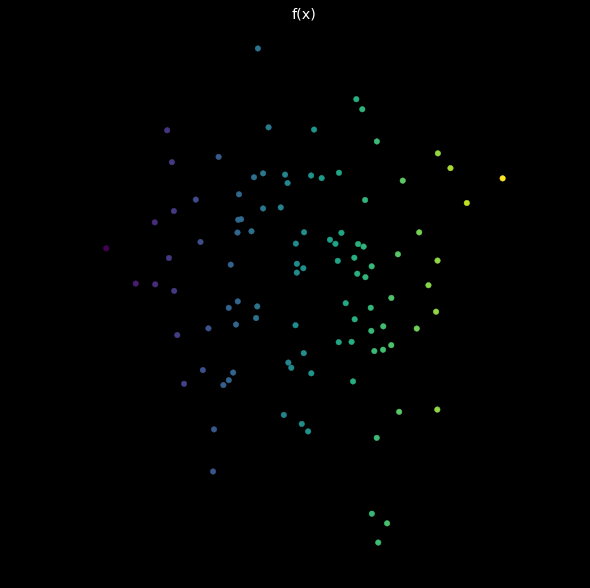

In [10]:
show_scatterplot(X, colors, title='f(x)')

In [11]:
# create 1-layer neural networks with ReLU activation
n_hidden = 5
n_output = 2
NL =  nn.ReLU()
linear_fc_relu = nn.Sequential(
            nn.Linear(X.shape[1], n_hidden), 
            NL, 
            nn.Linear(n_hidden, n_output)
        )

# We display the outputs from the 1-layer neural network with initial weights.
# First the data is streched by the linear transformation and then 
# the non-linearity introduced by the ReLu function curves the data.

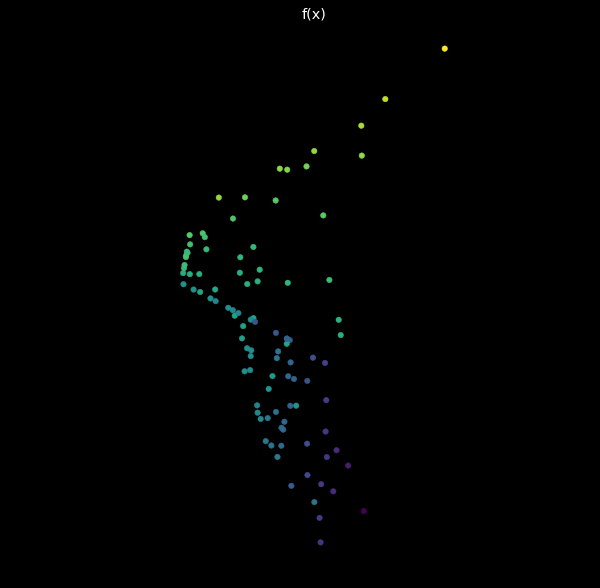

In [12]:
with torch.no_grad():
    Y = linear_fc_relu(X)

show_scatterplot(Y, colors, title='f(x)')

## 3.2. Sigmoid
The sigmoid function is another popular choice for a non-linear activation function which maps its input to values in the interval $(0,1)$. It is formally defined as:

$$\sigma(x) = \frac{1}{1+ e^{-x}}$$

Define a new neural network `linear_fc_sigmoid` which is the same architecture as in part `3.1.` but with a sigmoid unit instead of ReLU. 

Using the same $X$ as in part `3.1`, visualize the output of passing `X` through the neural network `linear_fc_sigmoid`.

In [13]:
# create 1-layer neural networks with Sigmoid activation
NL = nn.Sigmoid()
linear_fc_sigmoid = nn.Sequential(
            nn.Linear(X.shape[1], n_hidden), 
            NL, 
            nn.Linear(n_hidden, n_output)
        )

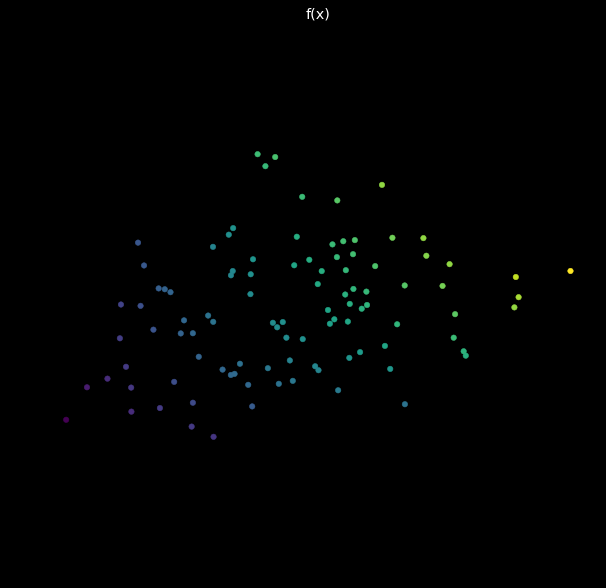

In [14]:
with torch.no_grad():
    Y = linear_fc_sigmoid(X)
show_scatterplot(Y, colors, title='f(x)')

# Non-linearity introduced by the Sigmoid function "squashes" the data.